# Neural Style Transfer for Stained-Glass Windows

Author: Vera Brennecke
Versions:
- Python: 3.9
- Tensorflow: 2.10.1

This notebook uses the technique of Neural Style Transfer as proposed by Gatys et al. [1] to apply the artistic style of a stained-glass window to a given photograph. It is partly based on [Tensorflow's](https://www.tensorflow.org/tutorials/generative/style_transfer) and [Keras'](https://keras.io/examples/generative/neural_style_transfer/) tutorial for Neural Style Transfer.
The general mechanism behind the Neural Style Transfer algorithm is the idea that the content and the style of an image can be reconstructed separately from outputs of the layers of a convolutional neural network (CNN) that has been trained on object recognition. The extracted representations of content and style of two different images are then used to optimize a whitenoise picture until it depicts the style of one and the content of the other image.

In [2]:
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
import time

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

Firstly, we define functions to load and display our images. We set a maximum dimension in order to keep the processing time of our operations low. We load the image and then convert it to a tensor, so it can be passed directly to the model that we are going to build later.

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        plt.imshow(image)
    if title:
        plt.title(title)

To easily display an image that is being processed as a tensor, we need a function that converts them back to a PIL image.

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Now, we load the image from which we will extract the content, as well as the image from which the desired style will be extracted. To get a look at the content of our images, we use pyplot to display them. Our style image is a stained-glass window that was chosen because of its bright colors and small window panes. The window frame that divides the large window into smaller parts was edited out to make the style pattern more uniform. The content image is a photo of a cabin in the mountains.

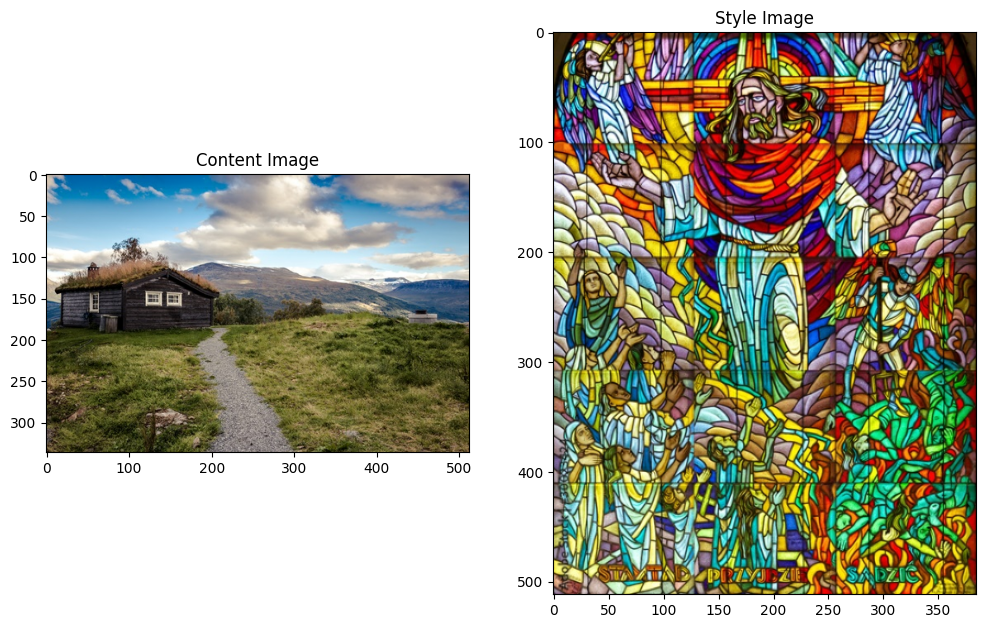

In [5]:
content_image = load_img('mountain_cabin.jpg')
style_image = load_img('window_edited.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

This function generates a whitenoise image, which we will need later on as an input image for the optimization process.

In [6]:
def whitenoise_image(width, height):
    arr = np.random.random_sample(size=(height, width, 3))
    img = arr.astype(np.float32)
    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis, :]
    return img

In their paper, Gatys et al. find that the representations of content and style of an image can be extracted separately from one another from the layers of a trained Convolutional Neural Network (CNN). They propose the usage of a VGG19-Network, which is known to perform well on visual object recognition tasks. In this project, we use a VGG19-Network provided by Keras that was pretrained for object recognition using the [ImageNet-Database](https://www.image-net.org/).

In [7]:
vgg19 = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

As our next step, we choose which layers of our CNN represent the content and the style of our input images. Each convolutional layer of a CNN consists of image multiple filters that extract certain features from an input image. Each layer therefore produces filtered representations of the input image as an output, so-called feature maps. The features captured by those feature maps get increasingly complex along the hierarchy of the network. In their paper, Gatys et al. state that the content of a given input image can be reconstructed almost perfectly from lower layers of a CNN that was trained on image recognition. The higher the layer used for reconstruction the fewer details will be visible in the reconstructed image. When it comes to style reconstruction, using a set of lower- and higher-level style layers produces overall larger structures in terms of style.
The following figure from Gatys et al. illustrates this.

![](content_style_layers.png)

For the purpose of style transfer, the feature maps from higher layers are used for content representation, as they capture a more global description of the images content. Since the defining structures of a stained-glass window's style are rather large, we use lower and higher layers for the style representation.

In [8]:
content_layers = [ 'block4_conv1' ]

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

Gatys et al. replace the average pooling layers in the VGG19 with max pooling layers. This also proved to be beneficial for our resulting images, so we implement a function transfers all the convolutional layers and weights to a new model while replacing the max pooling with average pooling.

In [9]:
def replace_max_pool_with_average_pool(vgg):
    vgg_outputs = vgg.input
    for layer in vgg.layers[1:]:
        if isinstance(layer, tf.keras.layers.MaxPool2D):
            kwargs = layer.get_config()
            vgg_outputs = tf.keras.layers.AveragePooling2D(**kwargs)(vgg_outputs)
        elif isinstance(layer, tf.keras.layers.Conv2D):
            kwargs = layer.get_config()
            vgg_outputs = tf.keras.layers.Conv2D(**kwargs)(vgg_outputs)
    model = tf.keras.Model([vgg.input], vgg_outputs)
    model.set_weights(vgg.get_weights())
    return model

We define a function that loads and sets up a pretrained VGG19 network without the top, as the fully connected layers are not used in neural style transfer. We then extract the outputs of a given set of layers from it and then set up a model with a new input layer and the extracted outputs. We now take a look at out resulting network.

In [10]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    vgg = replace_max_pool_with_average_pool(vgg)
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Let's take a look at our CNN
test_vgg = vgg_layers(style_layers + content_layers)
test_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (AveragePooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                           

For the style extraction, we need to be able to compute the correlations between the different feature maps in each layer, because a style usually consists of a combination of different structures. This is achieved by calculating the gram matrix for the vectorized feature maps of each layer.

In [11]:
# The input_tensor contains the feature maps of one layer
def gram_matrix(input_tensor):
    x = tf.transpose(input_tensor, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

We now define a model that contains a VGG19 CNN with our relevant style and content layers and extracts the corresponding style and content layer outputs when it is called with an input image.

In [12]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    # The input is a preprocessed tensor that contains an input image
    def call(self, inputs):
        # Expects float input in [0,1]
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # we replace the actual outputs (i.e. the feature maps) from each style layer with their corresponding
        # gram matrices, as those are needed for the calculation of the style loss later on
        style_outputs = [gram_matrix(style_output[0])
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

Now that we can extract the relevant feature maps from our CNN, we need loss functions that allow us to compare our target content and style representations to those of our generated whitenoise image that we want to optimize.

The content loss function receives the content layer outputs corresponding to the generated image and to the content image and calculates the squared error between them:
 $$ \mathcal{L}_{content} = = \frac{1}{2} \sum_{i,j}(F^l_{ij}-P^l_{ij})^2 $$
 With $F^l_{ij}$ and $P^l_{ij}$ being the activation of the $i^{th}$ filter at position $j$ in the feature representation of the generated image and the content image on content layer $l$.

In [13]:
def calc_content_loss(outputs, content_targets):
    content_outputs = outputs['content']

    content_loss = tf.add_n([tf.reduce_sum((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss = content_loss / 2.0
    return content_loss

Respectively, the style loss function receives the style layer outputs corresponding to the generated image and to the style image. The style loss for each individual style layer is calculated as follows:
 $$ E_{l} = \frac{1}{4N_{l}^2 M_{l}^2} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2 $$
 With $l$ being the current layer, $N_{l}$ the number of filters of that layer, $M_{l}$ the multiplication of the height and width of the feature maps and $G^l$ and $A^l$ the layer's style representations of the generated image and the style image (i.e. the gram matrices of the layer's feature maps).
All the individual layers' style weights are then summed up.

In [14]:
def calc_style_loss(outputs, style_targets):
    style_outputs = outputs['style']
    m = content_image.shape[1] * content_image.shape[2]
    style_loss = 0
    for name in style_outputs.keys():
        n = style_outputs[name].shape[1]
        style_loss_layer = tf.reduce_sum((style_outputs[name] - style_targets[name])**2) / (4.0 * (n**2) * (m**2))
        style_loss += style_loss_layer
    return style_loss

Now we use our style extractor model to extract the outputs of our chosen style and content layers from the CNN by inputting our style and target image. Those are our target outputs that contain a representation of the content of the content image and the style of the style image.

In [15]:
extractor = StyleContentExtractor(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

We set a style weight and a content weight. Those two weights are used to adapt the ratio between style and content optimization.

In [16]:
style_weight=1e-1
content_weight=1e-7

We also set a weight for the total variation loss. The original Neural Style Transfer algorithm by Gatys et al. does not use total variation loss, but it is proposed by many other implementations in order to reduce high frequency artifacts in the generated image.

In [17]:
total_variation_weight = 0.1

In the original paper an LBFGS optimizer is recommended, but Adam has been proven to work well too.

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

When implementing the train step function for the optimization process, we first extract the style and content representations from the input image. Then we calculate the style and content loss. At this point, we use the style and content weights that we set earlier. The style and content loss are then combined to a total loss. In addition to that, the total variation of the input image is calculated, weighed and added to the total loss. The total loss is now used to calculate the gradient and perform a gradient descent step on the image. At the end of each optimization step the updated image is clipped to make sure all its values stay within a valid range.

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

@tf.function()
def train_step(img):
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        style_loss = style_weight / len(style_layers) * calc_style_loss(outputs, style_targets)
        content_loss = content_weight / len(content_layers) * calc_content_loss(outputs, content_targets)
        loss = style_loss + content_loss
        loss = loss + (total_variation_weight * tf.image.total_variation(img))
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

As our starting image for the optimization process we generate a whitenoise image. We use the optimization function to optimize our generated image over the course of multiple epochs and steps. The following code only performs a single epoch to keep computation time short. This is not sufficient to produce a satisfying output, but should already show the beginnings of a pattern that resembles that of the style image. Actual results of longer optimization processes are shown in the next section.

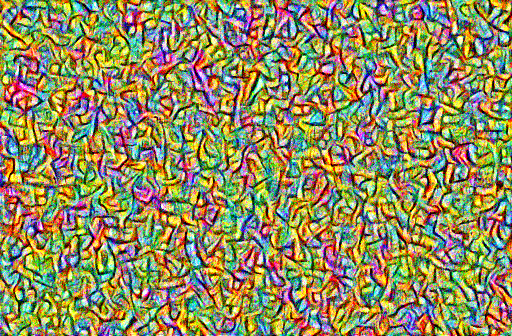

Train step: 100
Total time: 20.6


In [20]:
w, h = tensor_to_image(content_image).size
generated_image = tf.Variable(whitenoise_image(w, h))

start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(generated_image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(generated_image))
  print("Train step: {}".format(step))

tensor_to_image(generated_image)
end = time.time()
print("Total time: {:.1f}".format(end-start))


# Results and Conclusion
## Generated Images
| Content Image                              | Style Image                                     | Result                                            | Parameters                                                               |
|--------------------------------------------|-------------------------------------------------|---------------------------------------------------|--------------------------------------------------------------------------|
| <img src="mountain_cabin.jpg" width="300"> | <img src="window_edited.jpg" width="300">       | <img src="mountain_cabin_result.jpg" width="300"> | Style weight: $0.1$ <br/> Content weight: $1*10^{-6}$ <br/> Epochs: $20$ |
| <img src="beach_cabin.jpg" width="300">    | <img src="modern_glass_window.jpg" width="300"> | <img src="beach_cabin_result.jpg" width="300">    | Style weight: $0.1$ <br/> Content weight: $1*10^{-6}$ <br/> Epochs: $20$ |
| <img src="flowers.jpg" width="300">        | <img src="artsy_window.jpg" width="300">        | <img src="flowers_result.jpg" width="300">        | Style weight: $10.0$ <br/> Content weight: $1*10^{-6}$<br/> Epochs: $20$ |

## Conclusion
After running longer optimizations with different content and style images as well as adjusted values for the content and style weights, it can be concluded that Neural Style Transfer is generally successful in transferring the style of stained-glass windows to various photos. However, the optimization process is quite time-consuming, and finding the right ratio between content and style weight for each combination of content and style image can be challenging. Moreover, there are some restrictions that should be noted. If the content image depicts too many small details, those cannot be captured by the rather coarse patterns of the stained-glass window style. In addition to that, it can be hard to recognize the content of the generated image if the individual window panes of the stained-glass style are too large, as this makes it even harder to depict details. What is more, the algorithm will not always produce window panes that are completely closed off, which negatively affects the aesthetics of the result.
One advantage of using Neural Style Transfer for this task is that one only needs a single image tp represent the style. Specifically within the domain of stained-glass windows it can be quite hard to find a large amount of high-quality photos or illustrations of windows publicly available. This makes it harder to apply alternative machine learning solutions that require a vast amount of reference images, like Cycle GAN.

## References
<a id="1">[1]</a> L. Gatys, A. Ecker, and M. Bethge, “A Neural Algorithm of Artistic Style,” J. Vis., vol. 16, no. 12, p. 326, 2016, doi: 10.1167/16.12.326.
<a id="2">[2]</a> [https://www.tensorflow.org/tutorials/generative/style_transfer]()
<a id="3">[3]</a> [https://keras.io/examples/generative/neural_style_transfer/]()